In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
co2_df = pd.read_csv('sold_lunches.csv', delimiter=';', encoding='utf-8-sig')
co2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268323 entries, 0 to 268322
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Date             268323 non-null  object
 1   Receipt time     268323 non-null  object
 2   Restaurant       268323 non-null  object
 3   Food Category    268323 non-null  object
 4   Dish             268323 non-null  object
 5   pcs              268323 non-null  object
 6   Hiilijalanjälki  268323 non-null  object
dtypes: object(7)
memory usage: 14.3+ MB


/var/folders/3r/cnp9j40j6r30cv4942b63wmm0000gn/T/ipykernel_59989/1813644824.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  co2_df = pd.read_csv('sold_lunches.csv', delimiter=';', encoding='utf-8-sig')


### Data cleaning

In [3]:
co2_df['Hiilijalanjälki'] = co2_df['Hiilijalanjälki'].str.replace(',', '.', regex=True)

co2_df['pcs'] = pd.to_numeric(co2_df.pcs, errors='coerce')
co2_df['Hiilijalanjälki'] = pd.to_numeric(co2_df.Hiilijalanjälki, errors='coerce')
co2_df['Date'] = pd.to_datetime(co2_df.Date, format='%d.%m.%Y', errors='coerce')

co2_df = co2_df.dropna(subset=['Date','pcs','Hiilijalanjälki'])

rows_to_drop = co2_df[(co2_df['pcs'] <= 0) | (co2_df['Hiilijalanjälki'] <= 0)].index
co2_df.drop(rows_to_drop, inplace=True)

In [4]:
co2_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 259016 entries, 0 to 268322
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Date             259016 non-null  datetime64[ns]
 1   Receipt time     259016 non-null  object        
 2   Restaurant       259016 non-null  object        
 3   Food Category    259016 non-null  object        
 4   Dish             259016 non-null  object        
 5   pcs              259016 non-null  float64       
 6   Hiilijalanjälki  259016 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 15.8+ MB


In [5]:
co2_df.to_csv('cleaned_co2_df.csv')

In [6]:
co2_df.head()

,Date,Receipt time,Restaurant,Food Category,Dish,pcs,Hiilijalanjälki
0,2023-01-02,10:31,600 Chemicum,Liha,"Uunimakkaraa,sinappikastiketta",1.0,0.90
1,2023-01-02,10:32,600 Chemicum,Kala,Kalapuikot tillikermaviilikast,1.0,1.04
2,2023-01-02,10:32,600 Chemicum,Liha,"Uunimakkaraa,sinappikastiketta",1.0,0.90
3,2023-01-02,10:35,600 Chemicum,Kala,Kalapuikot tillikermaviilikast,1.0,1.04
4,2023-01-02,10:36,600 Chemicum,Liha,"Uunimakkaraa,sinappikastiketta",2.0,1.80


In [7]:
# Pivot the data to get the sum of each food category and carbon emissions by date and restaurant
pivot_df = co2_df.pivot_table(
    index=['Date', 'Restaurant'],
    columns='Food Category',
    values=['pcs', 'Hiilijalanjälki'],
    aggfunc='sum',
    fill_value=0
).reset_index()

# Flatten the multi-level column index
pivot_df.columns = ['_'.join(col).strip() if col[1] else col[0] for col in pivot_df.columns]

# Rename columns for clarity
pivot_df = pivot_df.rename(columns={
    'Date_': 'Date',
    'Restaurant_': 'Restaurant',
    'pcs_Liha': 'num_meat',
    'pcs_Kala': 'num_fish',
    'pcs_Kasvis': 'num_vegetarian',
    'pcs_Vegaani': 'num_vegan',
    'pcs_Kana': 'num_chicken',
    'Hiilijalanjälki': 'carbon_emissions_sum'
})

# Calculate the total carbon emissions
pivot_df['carbon_emissions_sum'] = pivot_df[[col for col in pivot_df.columns if 'Hiilijalanjälki' in col]].sum(axis=1)

# Drop the intermediate carbon columns to keep the final carbon emissions sum
pivot_df = pivot_df.drop(columns=[col for col in pivot_df.columns if 'Hiilijalanjälk' in col and col != 'carbon_emissions_sum'])
pivot_df['carbon_emissions_sum'] = pivot_df['carbon_emissions_sum'].round(2)

# Save the new dataset to a CSV file
output_file_path = 'grouped_co2_df.csv'
pivot_df.to_csv(output_file_path, index=False)

In [8]:
grouped_co2_df = pd.read_csv('grouped_co2_df.csv')

In [9]:
grouped_co2_df.head()

,Date,Restaurant,num_fish,num_chicken,num_vegetarian,num_meat,pcs_Not Mapped,num_vegan,carbon_emissions_sum
0,2023-01-02,600 Chemicum,85.0,0.0,0.0,171.0,0.0,91.0,273.82
1,2023-01-03,600 Chemicum,163.0,0.0,32.0,78.0,0.0,120.0,275.97
2,2023-01-04,600 Chemicum,70.0,0.0,0.0,218.0,0.0,137.0,246.55
3,2023-01-05,600 Chemicum,232.0,85.0,0.0,2.0,0.0,178.0,298.02
4,2023-01-09,600 Chemicum,107.0,0.0,0.0,283.0,0.0,216.0,402.71


### Linear regression

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import Ridge

Mean Absolute Error (MAE): 30.074138530967172
Mean Squared Error (MSE): 2193.7024905252774
Root Mean Squared Error (RMSE): 46.83697781161032
R² Score: 0.9442871884395658


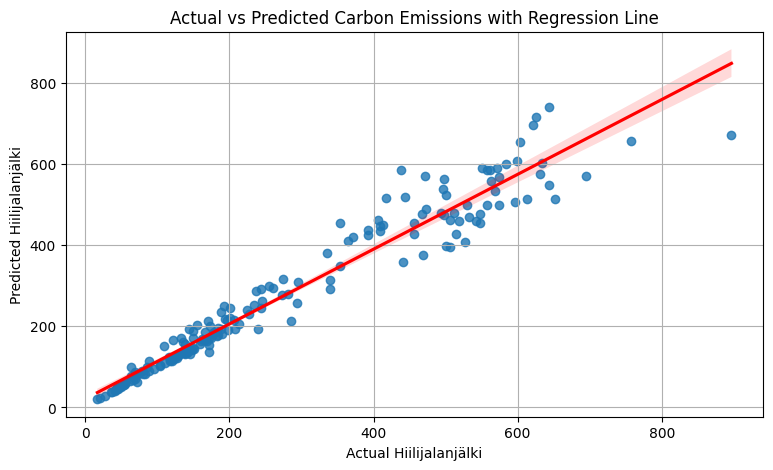

In [11]:
co2_ml = grouped_co2_df.copy()

# Prepare the features (X) and target (y)
X = co2_ml[['num_fish', 'num_chicken', 'num_vegetarian', 'num_meat', 'num_vegan']]
y = co2_ml['carbon_emissions_sum']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model using the training data
model.fit(X_train, y_train)

# Predict the carbon emissions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')

# Create a DataFrame for plotting
plot_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Plot actual vs predicted values with a regression line
plt.figure(figsize=(9, 5))
sns.regplot(x='Actual', y='Predicted', data=plot_df, line_kws={'color': 'red'})
plt.xlabel('Actual Hiilijalanjälki')
plt.ylabel('Predicted Hiilijalanjälki')
plt.title('Actual vs Predicted Carbon Emissions with Regression Line')
plt.grid(True)
plt.show()